In [ ]:
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

## K-means Clustering
## 1. Sybil Wallets Dataset

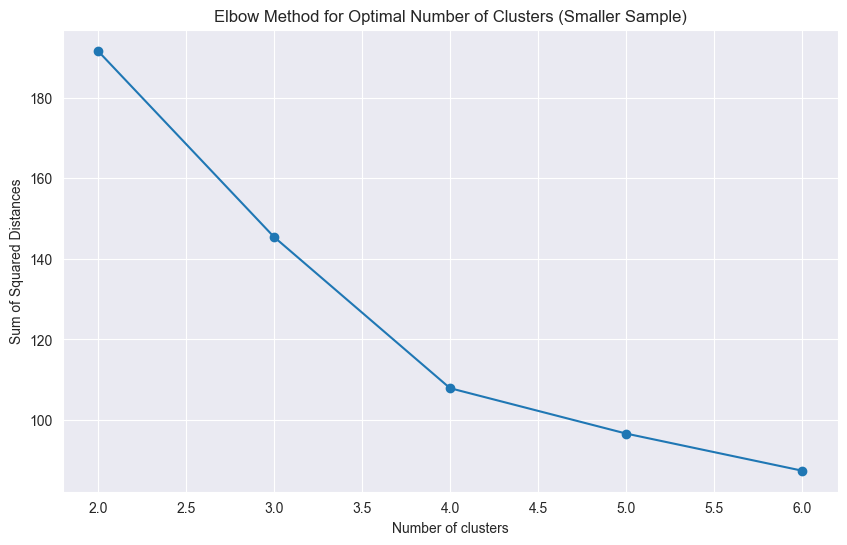

[191.61256912525218,
 145.45566632602365,
 107.91823206606605,
 96.65790123326107,
 87.44574500157677]

In [148]:
#Feature Engineering

# Load the uploaded dataset
file_path = "potencial_sybil_wallets.csv"
sybil_wallets_df = pd.read_csv(file_path)


# Convert the 'first_interact' and 'last_interact' columns to datetime
sybil_wallets_df['first_interact'] = pd.to_datetime(sybil_wallets_df['first_interact'], utc=True)
sybil_wallets_df['last_interact'] = pd.to_datetime(sybil_wallets_df['last_interact'], utc=True)

# Convert to UNIX timestamp
sybil_wallets_df['first_interact_unix'] = sybil_wallets_df['first_interact'].astype(np.int64) // 10**9
sybil_wallets_df['last_interact_unix'] = sybil_wallets_df['last_interact'].astype(np.int64) // 10**9

# Sort the 'chains_list' alphabetically
sybil_wallets_df['chains_list'] = sybil_wallets_df['chains_list'].apply(lambda x: sorted(x.split(',')))
sybil_wallets_df['chains_list'] = sybil_wallets_df['chains_list'].apply(lambda x: ','.join(x))

# Select features for clustering
features = sybil_wallets_df[['first_interact_unix', 'last_interact_unix', 'distinct_chains', 
                             'gas_spent_eth', 'tx_count', 'unique_contracts']]

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Use an even smaller sample for quicker computation
small_sample_size = 100
small_sampled_features_scaled = features_scaled[:small_sample_size]

# Elbow Method with a smaller sample and narrower range
k_range_narrow = range(2, 7)
sse_narrow_sampled = []
for k in k_range_narrow:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(small_sampled_features_scaled)
    sse_narrow_sampled.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range_narrow, sse_narrow_sampled, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters (Smaller Sample)')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squared Distances')
plt.show()

sse_narrow_sampled



In [149]:
# Apply K-means clustering with 2 clusters
kmeans_2_clusters = KMeans(n_clusters=2, random_state=42)
sybil_wallets_df['cluster_id'] = kmeans_2_clusters.fit_predict(features_scaled) + 1

# Calculate summary statistics for each of the 2 clusters
cluster_summary = sybil_wallets_df.groupby('cluster_id').agg({
    'first_interact_unix': ['min', 'max', 'mean', 'std'],
    'last_interact_unix': ['min', 'max', 'mean', 'std'],
    'distinct_chains': ['min', 'max', 'mean', 'std'],
    'gas_spent_eth': ['min', 'max', 'mean', 'std'],
    'tx_count': ['min', 'max', 'mean', 'std'],
    'unique_contracts': ['min', 'max', 'mean', 'std']
})

cluster_summary


first_interact_unix                                          \
                           min         max          mean           std   
cluster_id                                                               
1                   1688571116  1692501387  1.688912e+09  1.973610e+05   
2                   1686184568  1707565969  1.692345e+09  1.779560e+06   

           last_interact_unix                                          \
                          min         max          mean           std   
cluster_id                                                              
1                  1697785779  1715582652  1.714109e+09  1.432346e+06   
2                  1698643849  1715580322  1.713786e+09  1.683286e+06   

           distinct_chains      ... gas_spent_eth           tx_count       \
                       min max  ...          mean       std      min  max   
cluster_id                      ...                                         
1                        6   8  ...      0.139097  0.021590       94  209   
2                        6  13  ...      0.098430  0.025746       27  174   

                                  unique_contracts                           
                  mean        std              min max       mean       std  
cluster_id                                                                   
1           145.926007  20.535606               11  21  14.294658  1.369318  
2           115.020833  23.472617               11  28  14.407738  1.893540  

[2 rows x 24 columns]

In [150]:
# Convert timezone-aware datetime columns to timezone-unaware
sybil_wallets_df['first_interact'] = sybil_wallets_df['first_interact'].dt.tz_localize(None)
sybil_wallets_df['last_interact'] = sybil_wallets_df['last_interact'].dt.tz_localize(None)


 #Sort ascending the chain list 
def  transform_list(x):#
    raw_list  = x.strip('[]').split(" ")
    sorted_list = sorted(raw_list)
    return sorted_list
sybil_wallets_df['chains_list'] = sybil_wallets_df['chains_list'].apply(transform_list)

sybil_wallets_df.rename(columns = {"cluster_id": "sybil_cluster"}, inplace= True)

# Calculate the duration in days
sybil_wallets_df['duration'] = (sybil_wallets_df['last_interact'] - sybil_wallets_df['first_interact']).dt.days
display(sybil_wallets_df)
sybil_wallets_df.to_excel("clustering_sybil_wallets.xlsx", index = False)

,address,first_interact,last_interact,distinct_chains,chains_list,gas_spent_eth,tx_count,unique_contracts,unique_nft_addresses,first_interact_unix,last_interact_unix,sybil_cluster,duration
0,0x1e39b2552cc97acfbf46ebff6861d4fdee9daab9,2023-07-10 03:15:27,2024-05-02 10:23:28,8,"[arbitrum, avalanche_c, base, bnb, celo, gnosi...",0.197592,209,12,[0xfdc9018af0e37abf89233554c937eb5068127080],1688958927,1714645408,1,297
1,0x142c7c3ff8e274c98a8c5345355531f671ae1e91,2023-07-11 02:23:21,2024-04-29 20:57:22,8,"[arbitrum, avalanche_c, base, bnb, celo, gnosi...",0.188115,207,14,[0xfdc9018af0e37abf89233554c937eb5068127080],1689042201,1714424242,1,293
2,0x4357173850c7ea2c5c265146d5a076cdef5d3fef,2023-07-08 23:43:20,2024-04-18 19:10:46,8,"[arbitrum, avalanche_c, base, bnb, celo, gnosi...",0.189448,207,14,[0xfdc9018af0e37abf89233554c937eb5068127080],1688859800,1713467446,1,284
3,0x798616654a7068c40791b635498973d432cb0bca,2023-07-10 14:22:21,2024-05-12 02:19:23,8,"[arbitrum, avalanche_c, base, bnb, celo, gnosi...",0.197230,207,13,[0xfdc9018af0e37abf89233554c937eb5068127080],1688998941,1715480363,1,306
4,0x7c4c7fbc119cf5ad53a2c13e6771aa193611211f,2023-07-10 10:09:53,2024-05-12 19:54:27,7,"[arbitrum, avalanche_c, base, bnb, gnosis, opt...",0.151172,206,16,[0xfdc9018af0e37abf89233554c937eb5068127080 0x...,1688983793,1715543667,1,307
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2615,0x99cb69ba460018b8389b9f7d3810cf0d386df848,2023-07-11 06:24:24,2024-03-09 14:41:36,12,"[arbitrum, avalanche_c, base, bnb, celo, ether...",0.005825,46,20,[0xfdc9018af0e37abf89233554c937eb5068127080],1689056664,1709995296,2,242
2616,0xa33ed0d63f924bc0056cd713a4bbda8cc3bb2749,2023-06-10 20:22:34,2024-01-19 21:47:09,13,"[arbitrum, avalanche_c, base, bnb, celo, ether...",0.003731,44,20,[0xfdc9018af0e37abf89233554c937eb5068127080],1686428554,1705700829,2,223
2617,0x38abb8fb277458c75d90387f014d75b7aace180b,2023-07-22 13:31:39,2024-04-01 15:16:47,10,"[arbitrum, avalanche_c, base, bnb, ethereum, f...",0.003578,38,17,[0x13675ac4ba8bee98cf94781c71eafb29c0d1ec04 0x...,1690032699,1711984607,2,254
2618,0xadf9f8379b2edfa99aa64f7b4ea8afb4f791b2eb,2023-07-21 20:18:41,2024-05-13 06:05:22,9,"[arbitrum, avalanche_c, base, bnb, ethereum, f...",0.004011,29,11,[0xe7637699bd894427a3d0f16c6a4cbc1fea1fa8ec],1689970721,1715580322,2,296


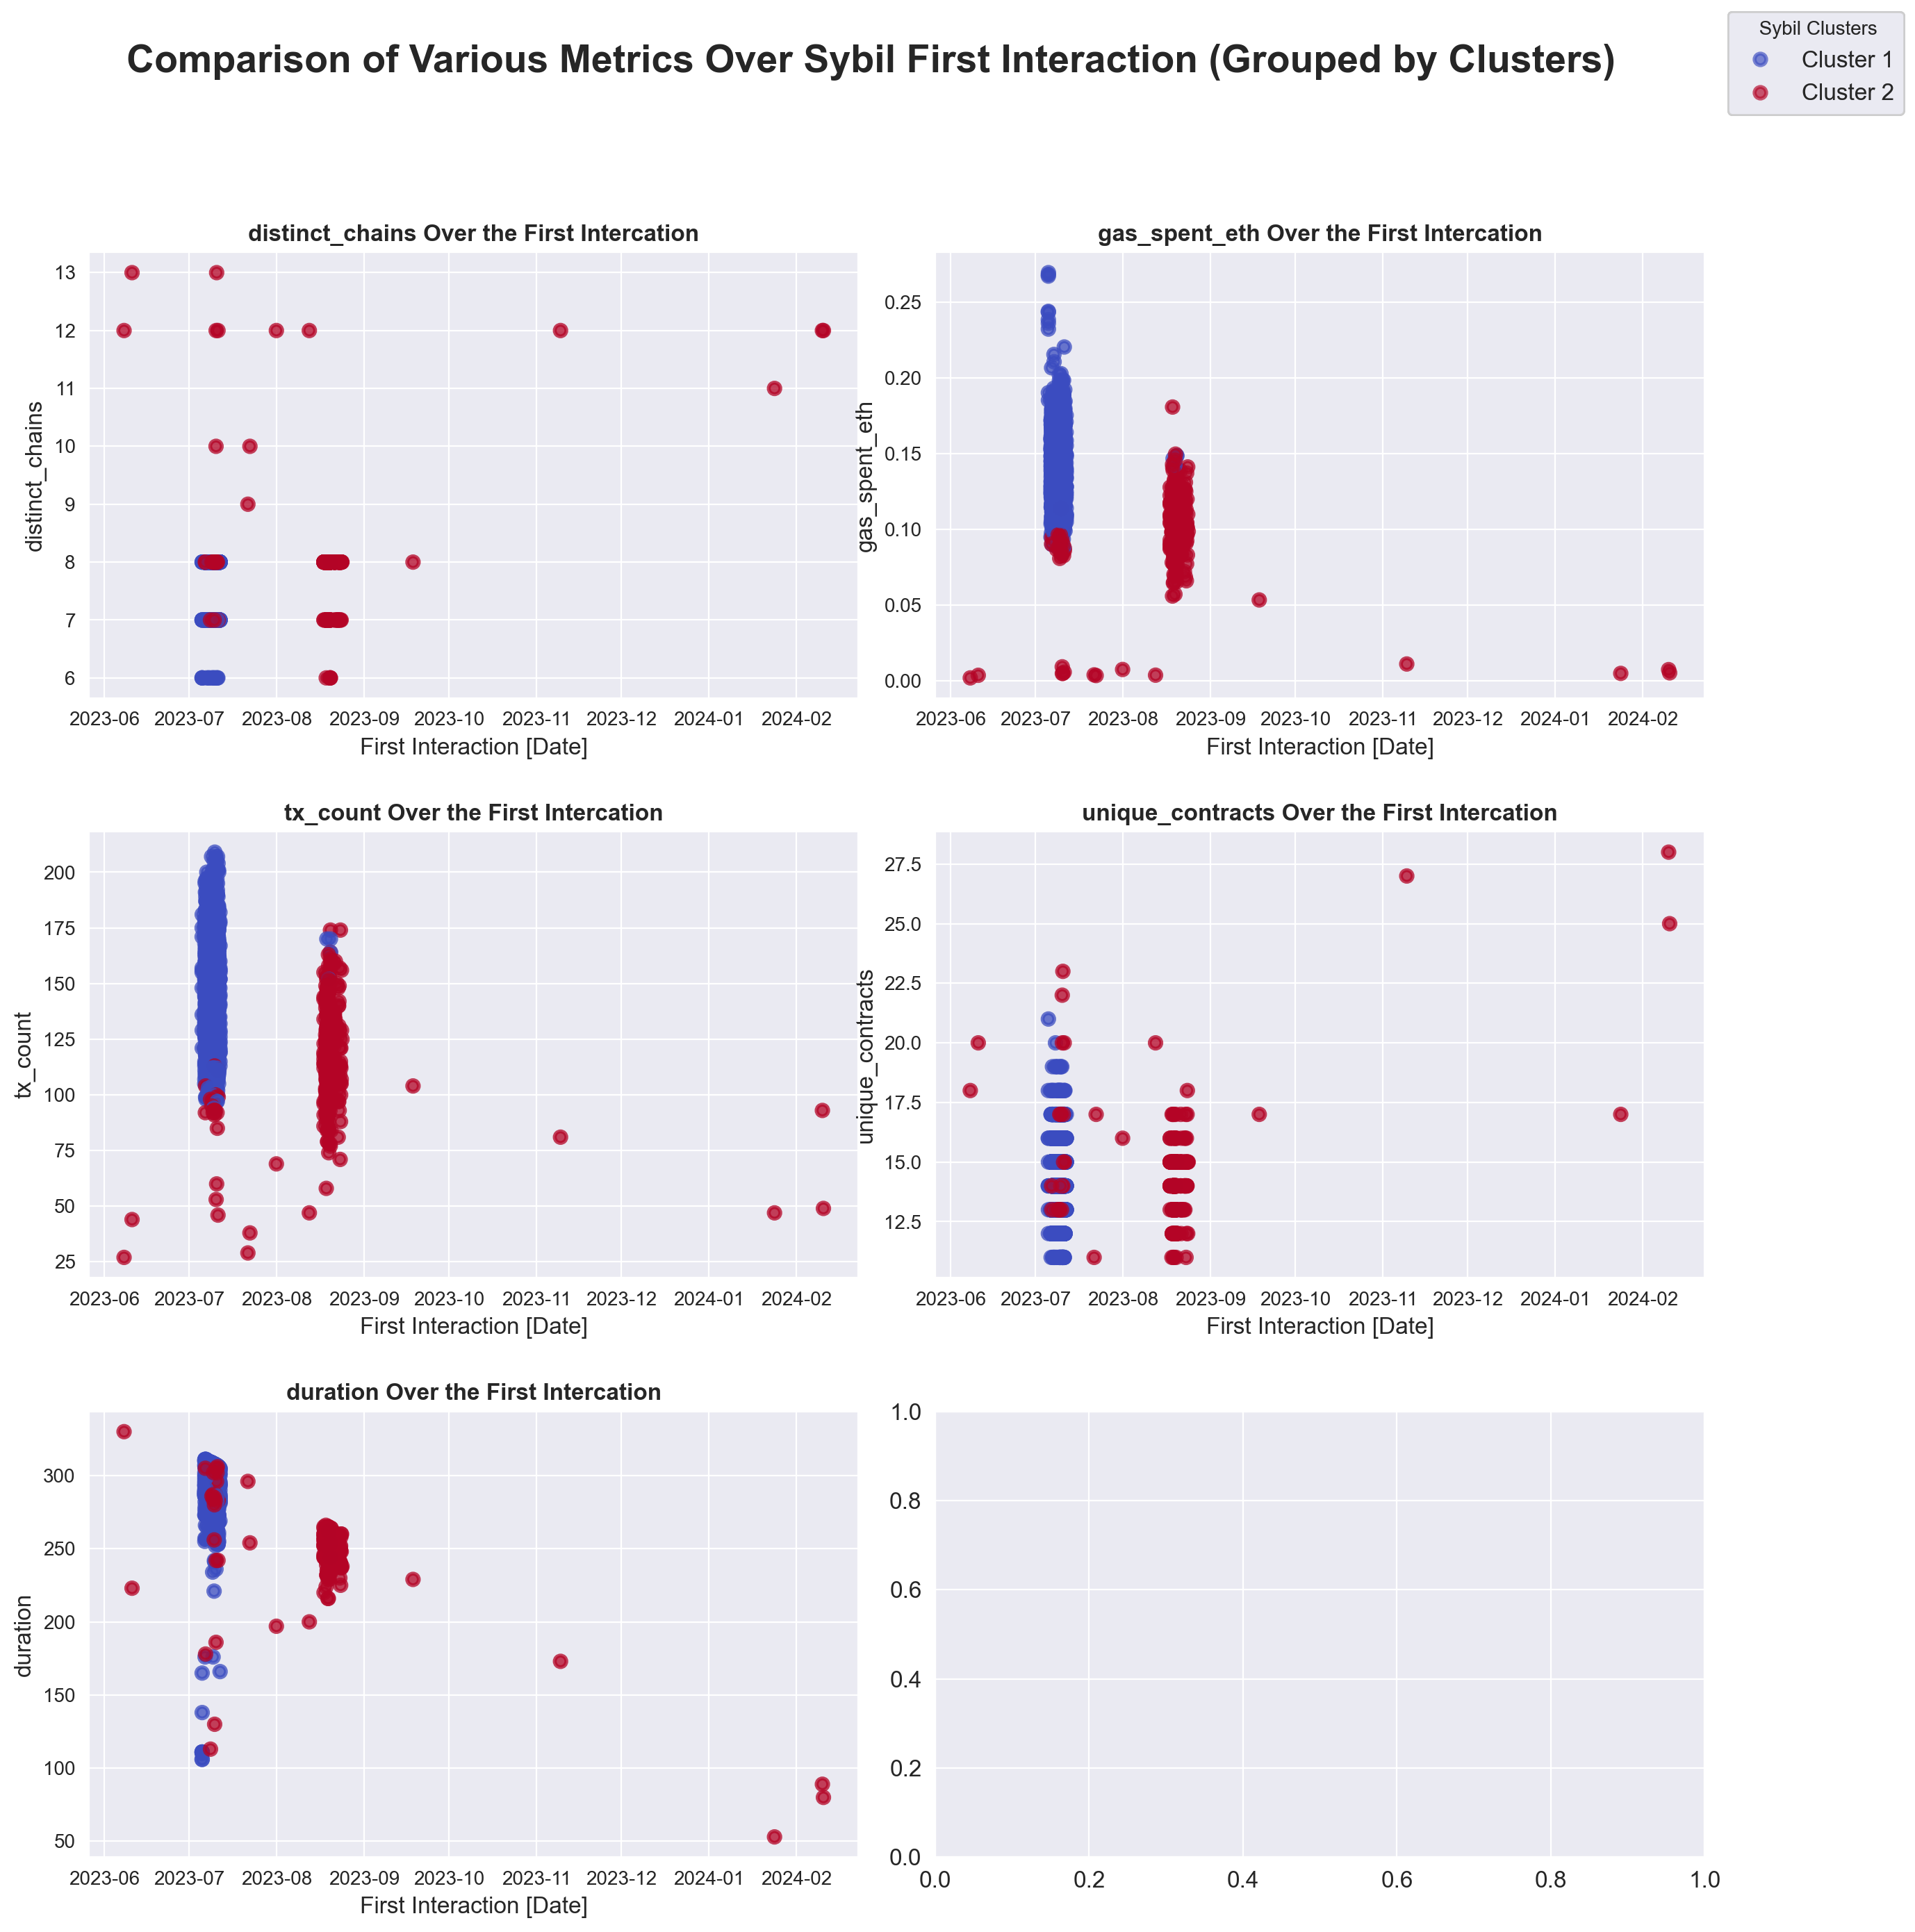

In [153]:
small_df = sybil_wallets_df
sea.set_style('darkgrid', {'axis.grid': True})
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2)
axes = [ax1,ax2,ax3,ax4, ax5]
vars =['distinct_chains', 'gas_spent_eth', 'tx_count', 'unique_contracts', 'duration']
colors = {1: 'blue', 2: 'red'}

# Convert 'first_interact' to datetime
small_df['first_interact'] = pd.to_datetime(small_df['first_interact'])

for field, ax in zip(vars,axes):
  #Plotting
    scatter = ax.scatter(x= small_df['first_interact'] , y = small_df[field] , c = small_df["sybil_cluster"], linewidth = 2, cmap='coolwarm', alpha=0.75)
  

    #labels
    ax.set_ylabel(field, fontsize = 12)
    ax.set_xlabel('First Interaction [Date]', fontsize = 12)
    ax.set_title(f"{field} Over the First Intercation" ,size = 12, fontweight = 'bold')
   
    #legends
    handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
    legend = fig.legend(handles, ["Cluster 1", "Cluster 2"], loc="upper right", title=" Sybil Clusters", fontsize=12)  

# Main title
fig.suptitle('Comparison of Various Metrics Over Sybil First Interaction (Grouped by Clusters)', fontsize=20, fontweight='bold')

#Setting
plt.gcf().set_size_inches(15,15)
plt.gcf().set_dpi(200)
plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig('Clustering Sybil Wallets.pdf')

    

## 2. Larger Dataset
Now let's dentify similar pattern activities in the larger dataset, considering that most of the sybil wallets are in the small dataset, you can follow these steps:
1. Extract Features and Define Patterns from Sybil Wallets:
    *  Extract the characteristics (mean, range, standard deviation) of the key features (interaction timestamps, distinct chains, gas spent, transaction count, unique contracts) from the sybil wallets in the small dataset.

2. Identify Patterns in the Larger Dataset:
    * Use clustering or another machine learning technique to identify similar patterns in the larger dataset.

3. Compare and Match Patterns:
    * Compare the clusters from the larger dataset with the defined patterns from the sybil wallets.


In [126]:
# Load Dataset
all_df = pd.read_csv("all_wallets.csv")

# Remove sybil wallets from the larger dataset
sybil_wallets = sybil_wallets_df['address'].unique()
all_df = all_df[~all_df['address'].isin(sybil_wallets)]

# Convert the 'first_interact' and 'last_interact' columns to datetime
all_df['first_interact'] = pd.to_datetime(all_df['first_interact'], utc=True)
all_df['last_interact'] = pd.to_datetime(all_df['last_interact'], utc=True)

# Preprocess the data: Convert date timestamp to UNIX timestamps
all_df['first_interact_unix'] = pd.to_datetime(all_df['first_interact']).astype(np.int64) // 10**9
all_df['last_interact_unix'] = pd.to_datetime(all_df['last_interact']).astype(np.int64) // 10**9

# features
features = ['first_interact_unix', 'last_interact_unix', 'distinct_chains', 'gas_spent_eth', 'tx_count', 'unique_contracts']

small_df = sybil_wallets_df # Sybil Wallets
large_df = all_df #filtered dataset

# Standardize features for pattern matching
scaler = StandardScaler()
sybil_data_scaled = scaler.fit_transform(small_df[features])
filtered_large_df_scaled = scaler.transform(large_df[features])

# Define sybil wallet patterns
sybil_patterns_mean = small_df[features].mean()
sybil_patterns_std = small_df[features].std()

# Apply K-Means clustering to the filtered larger dataset
kmeans = KMeans(n_clusters=2, random_state=42)
large_df['cluster_not_sybil'] = kmeans.fit_predict(filtered_large_df_scaled) + 1

# Summary statistics for each cluster in the larger dataset
def cluster_summary(cluster):
    return {
        'mean': cluster[features].mean(),
        'std': cluster[features].std()
    }

cluster_1_large = large_df[large_df['cluster_not_sybil'] == 1]
cluster_2_large = large_df[large_df['cluster_not_sybil'] == 2]

summary_cluster_1_large = cluster_summary(cluster_1_large)
summary_cluster_2_large = cluster_summary(cluster_2_large)

# Compare clusters to sybil wallet patterns
def compare_patterns(sybil_patterns, cluster_summary):
    comparisons = {}
    for feature in features:
        comparisons[feature] = {
            'sybil_mean': sybil_patterns_mean[feature],
            'cluster_mean': cluster_summary['mean'][feature],
            'sybil_std': sybil_patterns_std[feature],
            'cluster_std': cluster_summary['std'][feature]
        }
    return comparisons

comparison_cluster_1 = compare_patterns(sybil_patterns_mean, summary_cluster_1_large)
comparison_cluster_2 = compare_patterns(sybil_patterns_mean, summary_cluster_2_large)

# Print the comparisons
print("### Comparison with Sybil Wallet Patterns")

print("\n### Cluster A in Larger Dataset")
for feature, stats in comparison_cluster_1.items():
    print(f"{feature}: Sybil Mean = {stats['sybil_mean']}, Cluster Mean = {stats['cluster_mean']}, Sybil Std = {stats['sybil_std']}, Cluster Std = {stats['cluster_std']}")

print("\n### Cluster B in Larger Dataset")
for feature, stats in comparison_cluster_2.items():
    print(f"{feature}: Sybil Mean = {stats['sybil_mean']}, Cluster Mean = {stats['cluster_mean']}, Sybil Std = {stats['sybil_std']}, Cluster Std = {stats['cluster_std']}")

# Key Observations
print("\n### Key Observations:")
print("Comparing the sybil wallet patterns to the clusters identified in the larger dataset reveals the following similarities and differences...")


### Comparison with Sybil Wallet Patterns

### Cluster 1 in Larger Dataset
first_interact_unix: Sybil Mean = 1689352481.467939, Cluster Mean = 1699943651.719532, Sybil Std = 1325346.110644689, Cluster Std = 6371861.241339199
last_interact_unix: Sybil Mean = 1714067386.2687023, Cluster Mean = 1709846996.6833923, Sybil Std = 1470549.0185894636, Cluster Std = 6085979.814240187
distinct_chains: Sybil Mean = 7.783587786259542, Cluster Mean = 3.1366069350709798, Sybil Std = 0.5258837812283023, Cluster Std = 2.0143507043099396
gas_spent_eth: Sybil Mean = 0.13388198436603052, Cluster Mean = 0.01157836065511497, Sybil Std = 0.026001739344903515, Cluster Std = 0.23824367924883344
tx_count: Sybil Mean = 141.96259541984733, Cluster Mean = 67.51850127996276, Sybil Std = 23.343201434417004, Cluster Std = 52.46087496163924
unique_contracts: Sybil Mean = 14.30916030534351, Cluster Mean = 11.429057141397571, Sybil Std = 1.4472499170899606, Cluster Std = 5.061636246324975

### Cluster 2 in Larger Datase

In [134]:
all_wallet_cluster = pd.concat([cluster_1_large, cluster_2_large])
all_wallet_cluster.cluster_not_sybil = all_wallet_cluster.cluster_not_sybil.apply(lambda x: "A" if x == 1 else "B")


# Convert timezone-aware datetime columns to timezone-unaware
all_wallet_cluster['first_interact'] = all_wallet_cluster['first_interact'].dt.tz_localize(None)
all_wallet_cluster['last_interact'] = all_wallet_cluster['last_interact'].dt.tz_localize(None)

# Calculate the duration in days
all_wallet_cluster['duration'] = (sybil_wallets_df['last_interact'] - all_wallet_cluster['first_interact']).dt.days
display(all_wallet_cluster)
all_wallet_cluster.to_excel("all_wallets_clustered.xlsx",index = False) # without the sybil dataset

,address,first_interact,last_interact,distinct_chains,chains_list,gas_spent_eth,tx_count,unique_contracts,unique_nft_addresses,first_interact_unix,last_interact_unix,cluster_not_sybil,duration
0,0x9161d214972a52958f5a38695a524db4ec8b77de,2023-12-01 13:32:39,2024-04-22 10:31:45,1,[arbitrum],0.202633,275,29,NaN,1701437559,1713781905,A,152.0
1,0xca01a7d566d244369aa2c68fe9599d1778888888,2023-06-16 07:40:37,2024-04-10 09:30:38,2,[goerli arbitrum],0.198780,275,28,[0xbda90f447476e6ea5b78c28dfb6da6916327483e 0x...,1686901237,1712741438,A,318.0
2,0xfcaa07a4a18cc908d34940935d636d7de0763afe,2023-12-02 08:39:11,2024-04-15 04:06:34,3,[bnb ethereum arbitrum],0.053277,275,28,[0x7d5203e74a2afe3f474e21fef3e6ce04757652b9 0x...,1701506351,1713153994,A,138.0
3,0xfe2dd9c25c89a57c544ca7f82581ed4403d597fb,2024-02-18 09:00:58,2024-05-11 11:59:24,5,[base optimism arbitrum ethereum bnb],0.016917,275,27,[0x4f205d69834f9b101b9289f7affac9b77b3ff9b7],1708246858,1715428764,A,83.0
5,0x39d1733c93aae7a930182189ffb609b52130d191,2023-09-29 12:45:58,2024-05-01 15:30:33,4,[arbitrum optimism base ethereum],0.026390,275,26,NaN,1695991558,1714577433,A,213.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
370414,0xeba804b58d39c12c7543d7e203b420c729a4e4a8,2023-08-13 14:05:43,2023-11-18 01:22:58,12,[base polygon avalanche_c bnb zora fantom zksy...,0.001882,25,5,NaN,1691935543,1700270578,B,NaN
370416,0x201a0e48bcf185a1322e03270059a97efb885db8,2023-06-11 08:32:18,2023-07-18 07:18:56,7,[arbitrum polygon bnb optimism avalanche_c fan...,0.001981,25,5,NaN,1686472338,1689664736,B,NaN
370427,0x41a4d83f9f391b2326c0ee7baddaccb957a51416,2023-06-10 20:18:03,2023-10-21 22:07:45,10,[avalanche_c base arbitrum polygon zksync ethe...,0.002812,25,5,NaN,1686428283,1697926065,B,NaN
370436,0xec043d656d28cbbf36644aa746c82d538360e084,2023-07-11 23:16:01,2024-01-03 19:44:15,6,[bnb avalanche_c polygon optimism arbitrum base],0.002636,25,5,[0x8b5cc5e37c7fa12305669c3a7fc520663932b55d],1689117361,1704311055,B,NaN


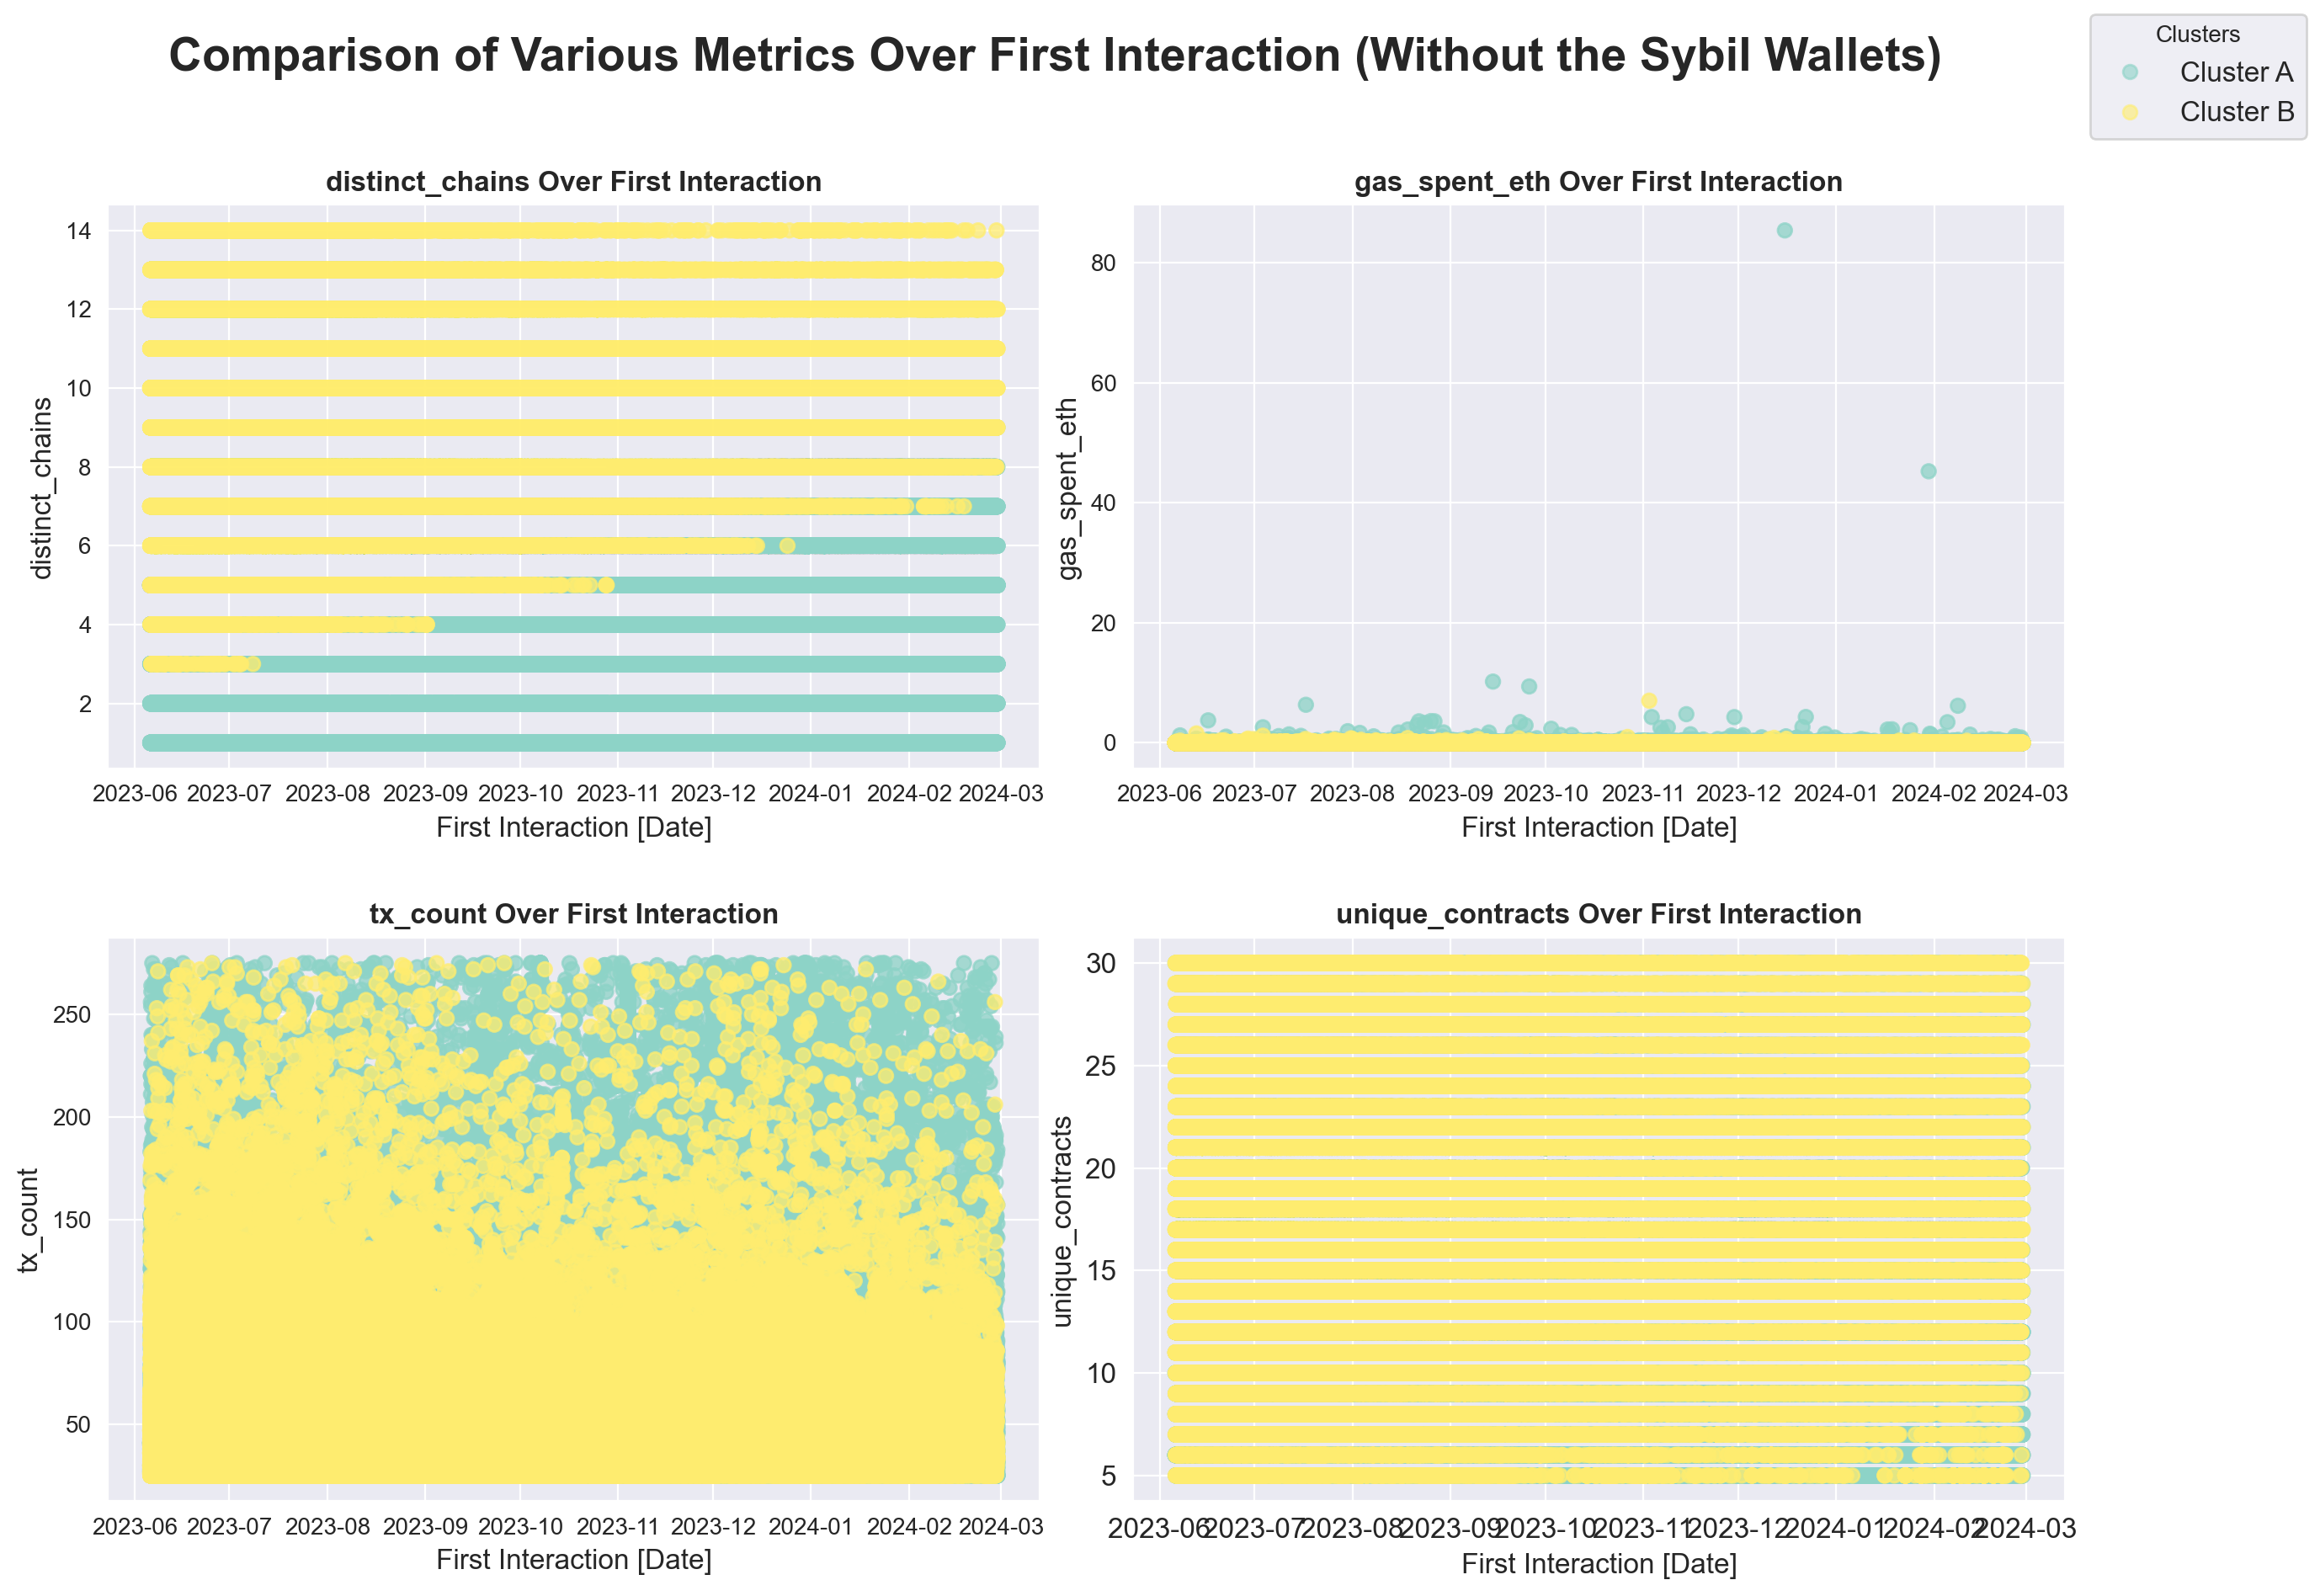

In [154]:


# Convert 'first_interact' to datetime
all_wallet_cluster['first_interact'] = pd.to_datetime(all_wallet_cluster['first_interact'])

# Map cluster labels to numeric values
cluster_map = {'A': 1, 'B': 2}
all_wallet_cluster['cluster_not_sybil_num'] = all_wallet_cluster['cluster_not_sybil'].map(cluster_map)

# Set the plot style
sea.set_style('darkgrid', {'axis.grid': True})

# Create subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

# Define variables to plot
vars = ['distinct_chains', 'gas_spent_eth', 'tx_count', 'unique_contracts']
axes = [ax1, ax2, ax3, ax4]

# Plot each variable
for field, ax in zip(vars, axes):
    scatter = ax.scatter(x=all_wallet_cluster['first_interact'], 
                         y=all_wallet_cluster[field], 
                         c=all_wallet_cluster['cluster_not_sybil_num'], 
                         cmap='Set3', alpha=0.75)
    
    # Labels
    ax.set_ylabel(field, fontsize=12)
    ax.set_xlabel('First Interaction [Date]', fontsize=12)
    ax.set_title(f"{field} Over First Interaction", size=12, fontweight='bold')

# Main title
fig.suptitle('Comparison of Various Metrics Over First Interaction (Without the Sybil Wallets)', fontsize=20, fontweight='bold')  

# Add a legend
handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
legend_labels = ["Cluster A", "Cluster B"]
legend = fig.legend(handles, legend_labels, loc="upper right", title="Clusters", fontsize=12)

# Setting
plt.gcf().set_size_inches(15, 10)
plt.gcf().set_dpi(200)
plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.savefig('Clustering Not Sybil Wallets.pdf')
plt.show()


In [142]:
final_df = pd.concat([sybil_wallets_df, all_wallet_cluster.drop(columns = ["cluster_not_sybil_num"])])
final_df.to_excel("clustered_all_wallets.xlsx", index = False)

## Charts